In [15]:
import sys
import os
sys.path.append('..')  # Adjust the path

In [16]:
import importlib
import src.hedging
importlib.reload(src.hedging)
from src.hedging import dynamic_delta_hedging, PnL

# Vanilla Delta Hedging Simulation

This section demonstrates a classic delta hedging strategy for a long call position. We'll simulate:
1. Going long on a call option
2. Delta hedging by continuously adjusting our position in the underlying asset

## Strategy Details:
- **Long Position**: 100 call options
- **Strike Price**: K = 100
- **Initial Price**: S0 = 100
- **Maturity**: T = 1 year
- **Interest Rate**: r = 5%
- **Volatility**: σ = 20%

## Implementation Steps:
1. Calculate BSM option prices and deltas along the price path
2. At each time step:
   - Compute required hedge adjustment based on delta changes
   - Short/buy the underlying to maintain delta neutrality
   - Track cash flows from hedge adjustments

## What we're tracking:
- **Total Delta Position**: Our exposure from the options
- **Adjustments**: Number of contracts bought/sold at each step
- **Cumulative Adjustments**: Running total of our position in the underlying
- **Cash Flows**: Money spent/received from hedge adjustments

The goal is to minimize our exposure to price movements by maintaining a delta-neutral portfolio. Perfect hedging would result in a final P&L close to zero (excluding transaction costs).

In [17]:
from src.simulation import GBM
from src.pricing import bsm_until_maturity, delta_until_maturity
from src.hedging import dynamic_delta_hedging, PnL

In [18]:
# Import other libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Generate dataframe with Geometric Brownian Motion

array_of_prices = np.full(100,100) # 100 stock with inital price 100
r = 0.05
volatility = 0.2
T = 3 # 3 Years
dt = 1 / 255 # Assuming 255 trading days
seed = 25 # For reproductibity

dataframe = GBM(array_of_prices, r, volatility, T, dt, seed)

# TO DO: Change to Parse_1, Parse_2, etc

dataframe

,Time,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Asset_8,Asset_9,...,Asset_91,Asset_92,Asset_93,Asset_94,Asset_95,Asset_96,Asset_97,Asset_98,Asset_99,Asset_100
0,0.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,...,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
1,0.0039,100.2981,98.7051,99.6930,98.1466,100.9638,100.3871,100.8954,100.6728,99.6608,...,99.4302,99.4033,98.8133,99.6433,100.6637,102.5119,102.3254,100.6926,98.5361,99.4606
2,0.0078,101.6084,100.7533,101.3780,97.6953,100.7214,100.0155,100.8557,101.0349,98.3008,...,100.0745,100.9379,97.2881,98.7124,101.6725,102.8123,103.5602,98.5155,98.5520,98.5764
3,0.0118,100.5573,101.0682,99.3871,97.2564,99.1604,101.1526,100.0486,101.7415,98.1976,...,101.8354,99.2652,97.4974,99.1367,102.5153,102.0569,102.7116,98.5201,98.2700,97.5056
4,0.0157,99.8273,99.6006,102.4761,98.1361,99.6112,100.2916,100.3260,103.2414,98.1102,...,101.4922,99.1084,97.2586,98.1276,102.9083,102.4591,104.0103,99.1779,99.2865,98.0393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2.9843,111.3026,162.2347,95.5646,67.9146,99.7649,45.7902,127.8793,141.3144,112.7973,...,98.7338,125.7014,110.7258,208.2227,85.5755,187.0247,71.5138,105.8688,129.4859,66.1051
762,2.9882,111.9936,164.2917,97.6741,67.4080,100.1885,45.2821,128.1615,142.7373,111.4604,...,100.2973,126.7106,110.9333,213.3864,84.6337,184.3280,70.7612,106.6216,128.8764,65.4088
763,2.9922,111.5994,163.9565,96.9277,65.6514,101.2015,45.7215,129.2985,142.4310,109.2212,...,98.3622,123.1144,109.6954,214.9256,85.7395,185.0997,71.4792,110.1967,132.3430,66.3132
764,2.9961,110.9976,169.3675,98.1279,65.8145,101.9503,46.4594,127.7137,141.9282,110.7920,...,98.2331,123.7623,108.5054,215.7212,86.7950,187.7181,73.0215,110.4270,132.3986,65.7970


In [20]:
K = 100 # Strike price (ATM option)

# Consider an ATM call option and generate option price data until maturity (3 years)
# TO DO: Correct RuntimeWarning

dataframe = GBM(array_of_prices, r, volatility, T, dt, seed)
bsm_prices = bsm_until_maturity(dataframe, K, r, volatility, T, is_call = True)

bsm_prices

,Time,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Asset_8,Asset_9,...,Asset_91,Asset_92,Asset_93,Asset_94,Asset_95,Asset_96,Asset_97,Asset_98,Asset_99,Asset_100
0,0.0000,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,...,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244,20.9244
1,0.0039,21.1240,19.9725,20.6838,19.5748,21.6124,21.1891,21.5621,21.3984,20.6604,...,20.4936,20.4742,20.0500,20.6477,21.3917,22.7641,22.6242,21.4130,19.8518,20.5156
2,0.0078,22.0714,21.4398,21.9005,19.2382,21.4164,20.9003,21.5150,21.6470,19.6668,...,20.9432,21.5756,18.9521,19.9603,22.1190,22.9721,23.5381,19.8197,19.8457,19.8631
3,0.0118,21.2782,21.6538,20.4273,18.9126,20.2640,21.7160,20.9066,22.1524,19.5760,...,22.2223,20.3393,19.0816,20.2469,22.7306,22.3874,22.8782,19.8055,19.6274,19.0874
4,0.0157,20.7281,20.5639,22.6832,19.5149,20.5715,21.0660,21.0912,23.2601,19.4966,...,21.9494,20.2089,18.8969,19.5089,23.0083,22.6704,23.8448,20.2589,20.3371,19.4464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2.9843,11.3810,62.3131,0.0368,0.0000,0.9213,0.0000,27.9577,41.3928,12.8757,...,0.5097,25.7798,10.8042,108.3011,0.0000,87.1031,0.0000,5.9564,29.5643,0.0000
762,2.9882,12.0524,64.3505,0.1598,0.0000,0.9952,0.0000,28.2203,42.7961,11.5192,...,1.0561,26.7694,10.9921,113.4452,0.0000,84.3868,0.0000,6.6813,28.9352,0.0000
763,2.9922,11.6386,63.9957,0.0289,0.0000,1.4968,0.0000,29.3377,42.4702,9.2604,...,0.1731,23.1537,9.7346,114.9649,0.0000,85.1389,0.0000,10.2359,32.3822,0.0000
764,2.9961,11.0172,69.3871,0.0369,0.0000,2.0024,0.0000,27.7333,41.9478,10.8116,...,0.0447,23.7819,8.5250,115.7408,0.0000,87.7377,0.0000,10.4466,32.4182,0.0000


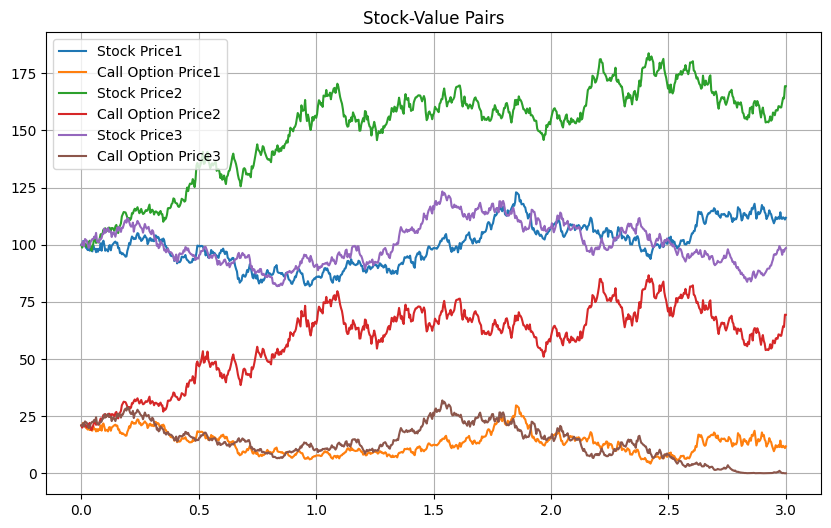

In [21]:
# Plot stock prices with corresponding call option prices until maturity

plt.figure(figsize=(10, 6))  # Use `figsize` instead of `size`
plt.title("Stock-Value Pairs")

for i in range(1, 4):
    
    plt.plot(dataframe["Time"], dataframe[f"Asset_{i}"], label=f"Stock Price{i}")
    plt.plot(dataframe["Time"], bsm_prices[f"Asset_{i}"], label=f"Call Option Price{i}")
    plt.grid(True)
    plt.legend()
plt.show()

In [22]:
# Compute option deltas. At maturity, in-the-money should be equal to 1 and out of the money equal to 0.

deltas = delta_until_maturity(dataframe, K, r, volatility, T, is_call=True) # False for puts
deltas

,Time,Delta_Asset_1,Delta_Asset_2,Delta_Asset_3,Delta_Asset_4,Delta_Asset_5,Delta_Asset_6,Delta_Asset_7,Delta_Asset_8,Delta_Asset_9,...,Delta_Asset_91,Delta_Asset_92,Delta_Asset_93,Delta_Asset_94,Delta_Asset_95,Delta_Asset_96,Delta_Asset_97,Delta_Asset_98,Delta_Asset_99,Delta_Asset_100
0,0.0000,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,...,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278,0.7278
1,0.0039,0.7305,0.7150,0.7247,0.7095,0.7368,0.7314,0.7362,0.7341,0.7244,...,0.7222,0.7219,0.7161,0.7242,0.7340,0.7510,0.7493,0.7343,0.7134,0.7225
2,0.0078,0.7427,0.7347,0.7405,0.7047,0.7344,0.7277,0.7357,0.7373,0.7109,...,0.7283,0.7364,0.7005,0.7150,0.7432,0.7535,0.7601,0.7130,0.7134,0.7136
3,0.0118,0.7327,0.7375,0.7215,0.7001,0.7193,0.7383,0.7279,0.7438,0.7097,...,0.7446,0.7203,0.7025,0.7190,0.7508,0.7466,0.7525,0.7129,0.7104,0.7026
4,0.0157,0.7256,0.7234,0.7503,0.7089,0.7235,0.7301,0.7304,0.7571,0.7086,...,0.7413,0.7186,0.6999,0.7088,0.7541,0.7501,0.7638,0.7193,0.7204,0.7079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2.9843,1.0000,1.0000,0.0386,0.0000,0.4800,0.0000,1.0000,1.0000,1.0000,...,0.3210,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.9898,1.0000,0.0000
762,2.9882,1.0000,1.0000,0.1476,0.0000,0.5496,0.0000,1.0000,1.0000,1.0000,...,0.5694,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.9986,1.0000,0.0000
763,2.9922,1.0000,1.0000,0.0417,0.0000,0.7597,0.0000,1.0000,1.0000,1.0000,...,0.1837,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
764,2.9961,1.0000,1.0000,0.0685,0.0000,0.9411,0.0000,1.0000,1.0000,1.0000,...,0.0805,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000


In [23]:
# Let's extract the data for asset 1 first ( dynamic delta hedging for one stock )


df_stock = pd.DataFrame({
})

df_stock["Time"] = dataframe["Time"]
df_stock["Asset_Price"] = dataframe["Asset_1"]
df_stock["Call_Price"] = bsm_prices["Asset_1"]
df_stock["Delta"] = 100 * deltas["Delta_Asset_1"] # Adjust delta to have base 100

df_stock

,Time,Asset_Price,Call_Price,Delta
0,0.0000,100.0000,20.9244,72.7815
1,0.0039,100.2981,21.1240,73.0531
2,0.0078,101.6084,22.0714,74.2653
3,0.0118,100.5573,21.2782,73.2734
4,0.0157,99.8273,20.7281,72.5623
...,...,...,...,...
761,2.9843,111.3026,11.3810,99.9992
762,2.9882,111.9936,12.0524,100.0000
763,2.9922,111.5994,11.6386,100.0000
764,2.9961,110.9976,11.0172,100.0000


In [ ]:
# TO DO: Adjust this function

# Numba-compiled simulation function.
@nb.njit
def simulate_dynamic_hedging(T, dt, initial_S, K, r, sigma, normals):
    # Allocate arrays to hold simulation results.
    steps = int(T / dt)
    n_steps = steps + 1
    stock_prices       = np.empty(n_steps)
    option_prices      = np.empty(n_steps)
    deltas             = np.empty(n_steps)
    portfolio_values   = np.empty(n_steps)
    cash_accounts      = np.empty(n_steps)
    shares_held_list   = np.empty(n_steps)
    
    # Initial conditions:
    stock_prices[0] = initial_S
    option_prices[0] = black_scholes_call(initial_S, K, T, r, sigma)
    deltas[0] = black_scholes_delta(initial_S, K, T, r, sigma)
    
    cash_account = 0.0
    shares_held = 0.0
    
    portfolio_values[0] = cash_account + shares_held * initial_S
    cash_accounts[0] = cash_account
    shares_held_list[0] = shares_held
    
    current_S = initial_S
    current_delta = deltas[0]
    
    # Loop over time steps
    for i in range(1, n_steps):
        time_to_expiry = T - i * dt
        
        # Simulate stock price movement using Geometric Brownian Motion
        # Use the pre-generated normal value for this step.
        z = normals[i - 1]
        current_S = current_S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        stock_prices[i] = current_S
        
        # Recalculate option price and delta
        option_prices[i] = black_scholes_call(current_S, K, time_to_expiry, r, sigma)
        current_delta = black_scholes_delta(current_S, K, time_to_expiry, r, sigma)
        deltas[i] = current_delta
        
        # Adjust hedge: calculate change in delta relative to shares held
        delta_change = current_delta - shares_held
        shares_to_trade = delta_change
        
        # Trade shares: update cash account (negative because buying shares uses cash)
        cash_account -= shares_to_trade * current_S
        
        # Update number of shares held
        shares_held += shares_to_trade
        
        # Let cash account grow with the risk-free rate over dt
        cash_account *= np.exp(r * dt)
        
        # Record updated cash and shares
        cash_accounts[i] = cash_account
        shares_held_list[i] = shares_held
        
        # Update portfolio value (cash + value of shares)
        portfolio_values[i] = cash_account + shares_held * current_S

    return stock_prices, option_prices, deltas, portfolio_values, cash_accounts, shares_held_list

In [28]:
# Example usage:
# Assuming df is the given DataFrame
df = dynamic_delta_hedging(df_stock)
df

,Time,Asset_Price,Call_Price,Delta,Total_Delta_Position,Adjustments_(Contracts),Total_Adjustments,Ajustment_Cash_Flow
0,0.0000,100.0000,20.9244,72.7815,0.0000,-0.0000,-0.0000,0.0000
1,0.0039,100.2981,21.1240,73.0531,27.1613,-0.2716,-0.2716,27.2423
2,0.0078,101.6084,22.0714,74.2653,121.2155,-1.2122,-1.4838,123.1650
3,0.0118,100.5573,21.2782,73.2734,-99.1832,0.9918,-0.4919,-99.7360
4,0.0157,99.8273,20.7281,72.5623,-71.1162,0.7112,0.2192,-70.9934
...,...,...,...,...,...,...,...,...
761,2.9843,111.3026,11.3810,99.9992,0.3731,-0.0037,-27.2177,0.4153
762,2.9882,111.9936,12.0524,100.0000,0.0777,-0.0008,-27.2185,0.0871
763,2.9922,111.5994,11.6386,100.0000,0.0007,-0.0000,-27.2185,0.0008
764,2.9961,110.9976,11.0172,100.0000,0.0000,-0.0000,-27.2185,0.0000


In [ ]:
# Let's print the PnL of the hedge:

# TO DO: 

profit = PnL(df, 100,)
print(f"Total PnL: {profit}")

Adjustment Cash Flows: 4012.058033081291
Option Profit: -915.6151647575797
Initial Underlying Hedge Position: -856.5078397315496
Total PnL: 2239.9350285921614


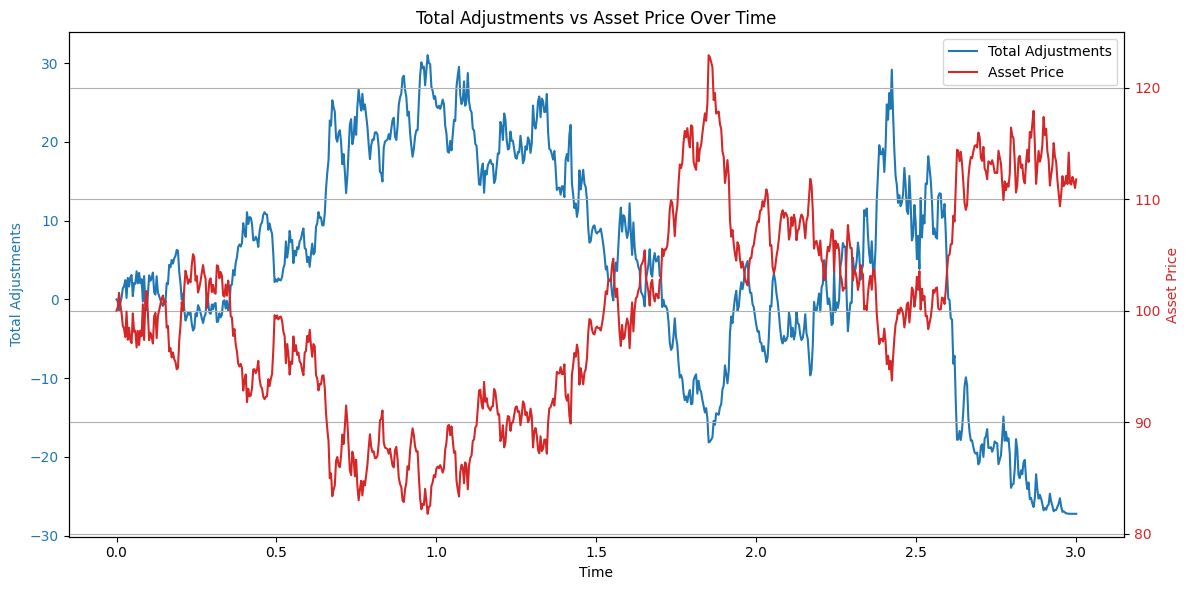

In [ ]:
### Let's plot the Hedge

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Adjustments on primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Adjustments', color=color1)
line1 = ax1.plot(df["Time"], df["Total_Adjustments"], color=color1, label='Total Adjustments')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()

# Plot Asset Price on secondary y-axis
color2 = 'tab:red'
ax2.set_ylabel('Asset Price', color=color2)
line2 = ax2.plot(df["Time"], df["Asset_Price"], color=color2, label='Asset Price')
ax2.tick_params(axis='y', labelcolor=color2)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add title
plt.title('Total Adjustments vs Asset Price Over Time')
plt.grid(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [29]:
%pip install numba

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.7 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 34.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
